## Import all libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Function to generate data

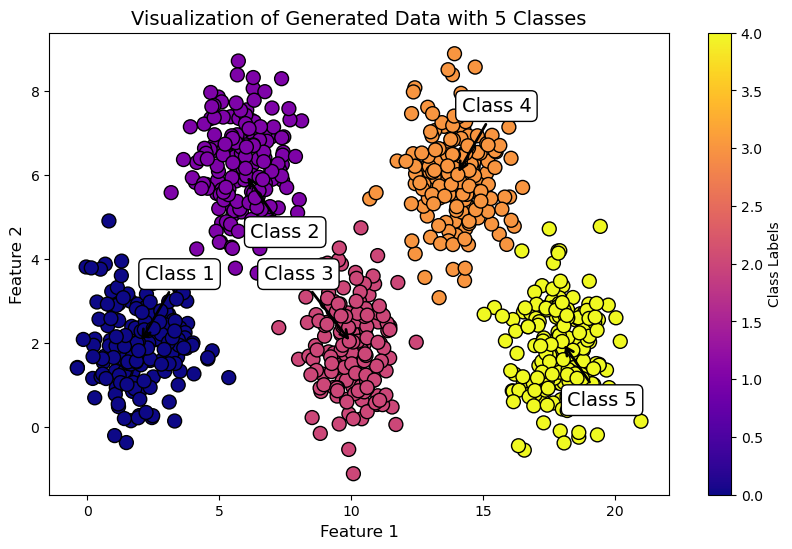

In [56]:
# Function to generate data for 5 classes
def generate_data(samples_per_class=180):
    np.random.seed(32)
    # Class centers for 5 classes
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([14, 6])
    class5 = np.random.randn(samples_per_class, 2) + np.array([18, 2])

    # Combine the data
    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0] * samples_per_class + [1] * samples_per_class +
                  [2] * samples_per_class + [3] * samples_per_class + [4] * samples_per_class)

    return X, y

# Generate data
X, y = generate_data()

# Encode the classes using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

# Plot the generated data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma", s=100, edgecolor="k")

# Class centers for annotations
centers = [(2, 2), (6, 6), (10, 2), (14, 6), (18, 2)]  # Updated centers for 5 classes
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5), (1.5, 1.5), (1.5, -1.5)]  # Offset for better placement

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',
                 xy=center,
                 xytext=(center[0] + offset[0], center[1] + offset[1]),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                 fontsize=14,
                 color="black",
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Adding plot details
plt.title("Visualization of Generated Data with 5 Classes", fontsize=14)
plt.colorbar(scatter, label="Class Labels")
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.show()


The scatter plot displays synthetic data for **five distinct classes** (labeled 0 to 4), each represented by a different color.
* Each class forms a **cluster of points** around a unique center in 2D feature space (e.g., Class 1 near \[2, 2], Class 2 near \[6, 6], etc.).
* The **x-axis and y-axis** correspond to **Feature 1** and **Feature 2**, respectively.
* **Random noise** around each center adds variability to the data points while maintaining clear class separation.
* **Annotations** mark the central point of each class for better visual identification of clusters.
* A **color bar** provides a reference for mapping class labels to their corresponding colors, enhancing interpretability.


In [57]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

## Split the data into training, validation, and test sets

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

## Print the sizes of the splits

In [59]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 540 samples
Validation set: 180 samples
Test set: 180 samples


## Define the custom neural network class

In [60]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        # Initialize weights for all layers
        self.W1 = np.random.randn(input_size, hidden_size1)  # Input to Hidden Layer 1
        self.W2 = np.random.randn(hidden_size1, hidden_size2)  # Hidden Layer 1 to Hidden Layer 2
        self.W3 = np.random.randn(hidden_size2, hidden_size3)  # Hidden Layer 2 to Hidden Layer 3
        self.W4 = np.random.randn(hidden_size3, output_size)  # Hidden Layer 3 to Output Layer
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feed_forward(self, x):
        # Layer 1
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        # Layer 2
        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        # Layer 3
        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        # Output Layer
        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.sigmoid(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        # Output Layer Error
        output_error = y - output
        output_delta = output_error * self.sigmoid(output, derivative=True)

        # Hidden Layer 3 Error
        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        # Hidden Layer 2 Error
        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        # Hidden Layer 1 Error
        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        # Update weights
        self.W4 += np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 += np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 += np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 += np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

The `NeuralNet` class defines a custom **multi-layer perceptron** with **three hidden layers** and implements both **forward propagation** and **backpropagation**.
* All layers use the **sigmoid activation function**, adding non-linearity and enabling the model to learn complex patterns.
* During **forward propagation**, input data flows through each layer via **matrix multiplications** and activations, producing the final prediction.
* **Backpropagation** computes the **error at the output layer** and propagates it backward, calculating gradients for each weight matrix.
* Weights are updated using **gradient descent**, with the **learning rate (lr)** determining the adjustment magnitude to promote smooth convergence.
* The `train` method enables the network to perform **iterative learning** over epochs, continuously improving prediction accuracy.


## Train the Neural Network

In [61]:
from sklearn.metrics import accuracy_score # Importing the accuracy_score function
input_size = X_train.shape[1]
hidden_size1 = 15  # Neurons in the first hidden layer
hidden_size2 = 15  # Neurons in the second hidden layer
hidden_size3 = 15  # Neurons in the third hidden layer
output_size = y_train.shape[1]  # Number of output classes
lr = 0.001  # Learning rate
epochs = 1000

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    # Compute loss
    train_loss = np.mean((y_train - train_output) ** 2)
    val_loss = np.mean((y_val - val_output) ** 2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Compute accuracy
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
              f"Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")


Epoch 0: Train Loss = 0.2557, Validation Loss = 0.2531, Train Accuracy = 18.89%, Validation Accuracy = 20.56%
Epoch 50: Train Loss = 0.1383, Validation Loss = 0.1383, Train Accuracy = 56.11%, Validation Accuracy = 56.11%
Epoch 100: Train Loss = 0.1247, Validation Loss = 0.1252, Train Accuracy = 56.11%, Validation Accuracy = 60.00%
Epoch 150: Train Loss = 0.1146, Validation Loss = 0.1158, Train Accuracy = 65.00%, Validation Accuracy = 67.78%
Epoch 200: Train Loss = 0.1050, Validation Loss = 0.1069, Train Accuracy = 69.26%, Validation Accuracy = 63.89%
Epoch 250: Train Loss = 0.0971, Validation Loss = 0.0993, Train Accuracy = 73.70%, Validation Accuracy = 70.00%
Epoch 300: Train Loss = 0.0907, Validation Loss = 0.0931, Train Accuracy = 74.81%, Validation Accuracy = 71.67%
Epoch 350: Train Loss = 0.0848, Validation Loss = 0.0874, Train Accuracy = 77.59%, Validation Accuracy = 73.33%
Epoch 400: Train Loss = 0.0795, Validation Loss = 0.0822, Train Accuracy = 79.26%, Validation Accuracy = 73

The neural network is trained using the custom `train` method over **900 epochs** with a **learning rate of 0.001**.
* The network consists of an **input layer, three hidden layers**, and an **output layer**.
* In each epoch, the model computes:

  * **Mean Squared Error (MSE)** for both training and validation sets.
  * **Accuracy** using `accuracy_score` for both sets.
* Training and validation metrics are stored in:

  * `train_losses`, `val_losses` for loss values.
  * `train_accuracies`, `val_accuracies` for accuracy scores.
* Every **50 epochs**, a summary is printed showing:

  * Current epoch.
  * Training and validation losses and accuracies.
* This helps monitor **learning progress**, detect **convergence**, and spot potential **overfitting**.
* Results usually show **decreasing loss** and **increasing accuracy**, indicating effective learning.


# Visualize Loss and Accuracy

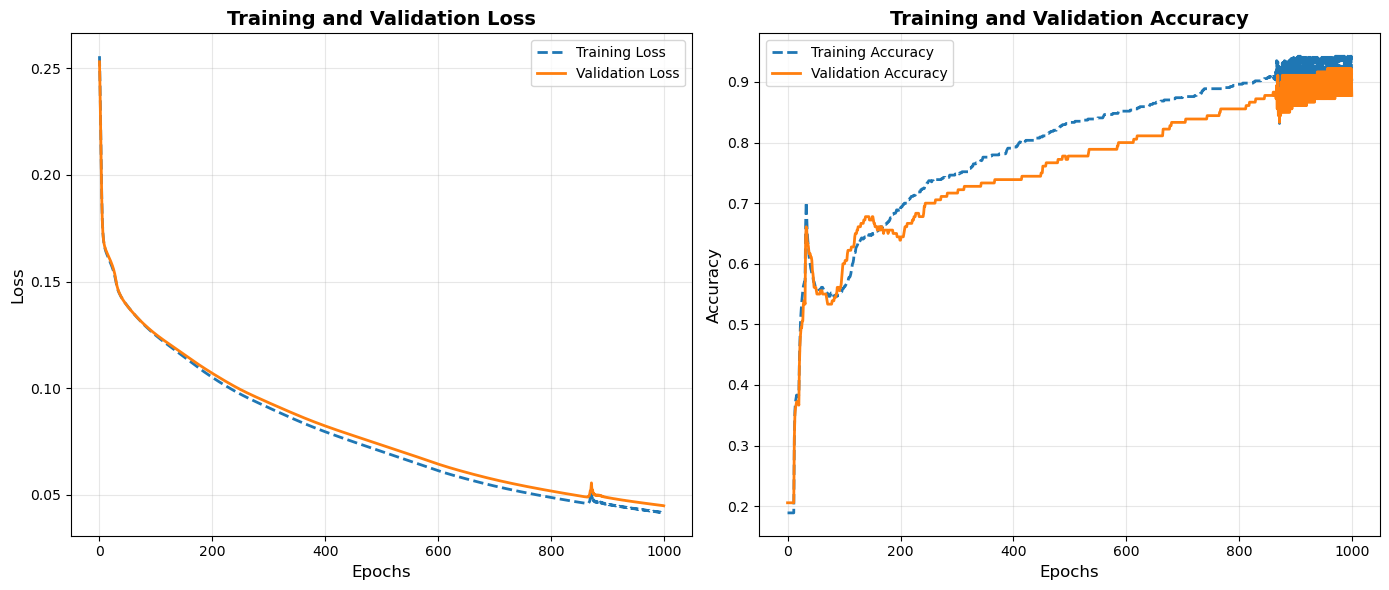

In [79]:
plt.figure(figsize=(14, 6))

# Subplot 1: Training and Validation Loss

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--', linewidth=2)
plt.plot(val_losses, label="Validation Loss", linestyle='-', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)


# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--', linewidth=2)
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='-', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)


# Adjust layout for better presentation
plt.tight_layout()
plt.show()


**Training and Validation Loss:**

* **Training Loss:** Starts high, drops rapidly early on as the model learns, then continues to decrease slowly and stabilizes, showing the model is fitting the training data.
* **Validation Loss:** Also drops initially but more slowly and with some bumps. It generally follows the training loss but starts to plateau or even slightly increase later, suggesting the model might be starting to overfit the training data and not generalize as well to new data.

**Training and Validation Accuracy:**

* **Training Accuracy:** Increases quickly in the beginning, mirroring the loss decrease, and eventually reaches a high, stable level, indicating good learning on the training set.
* **Validation Accuracy:** Starts lower but also improves over time. However, it lags behind the training accuracy, and the gap widens later in training. This difference, along with potential dips or plateaus in validation accuracy, reinforces the possibility of overfitting, where the model learns the training data too well but performs relatively worse on unseen data.

**Overall:**

The plots indicate that the model is learning, but there's a growing sign of overfitting as training progresses. The model performs very well on the training data (low loss, high accuracy) but its ability to generalize to new, unseen data (as indicated by the validation set) is not improving at the same rate and might even be getting worse. Techniques to combat overfitting should be considered.

## Evaluate the Model

In [63]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

## Compute accuracy

In [64]:
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 89.44%


## Plot Actual Vs Predicted

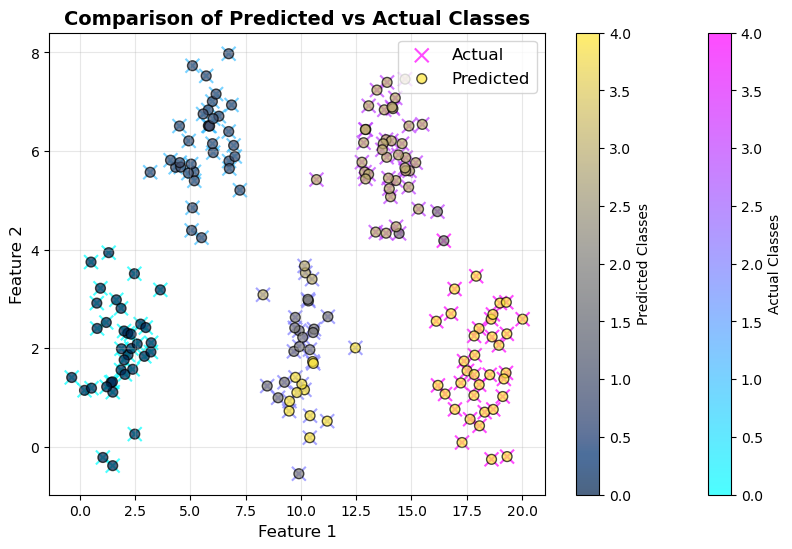

In [78]:
predicted_output = nn.feed_forward(X_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Visualize the Comparison using different colors and markers for better distinction
plt.figure(figsize=(10, 6))

# Create a scatter plot for actual classes using color coding
scatter_actual = plt.scatter(X_test[:, 0], X_test[:, 1],
                            c=actual_classes, cmap='cool',
                            s=100, marker='x', alpha=0.7, label='Actual')

# Overlay predicted classes with different color map and marker
scatter_predicted = plt.scatter(X_test[:, 0], X_test[:, 1],
                                 c=predicted_classes, cmap='cividis',
                                 s=50, marker='o', alpha=0.7, edgecolor='k', label='Predicted')

# Add plot details and labels
plt.title("Comparison of Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend for clarity
plt.legend(loc="best", fontsize=12)

# Display a grid for better readability
plt.grid(True, alpha=0.3)

# Add colorbar to map the color to class labels
cbar_actual = plt.colorbar(scatter_actual, label="Actual Classes")
cbar_predicted = plt.colorbar(scatter_predicted, label="Predicted Classes")

# Show the plot
plt.show()

This scatter plot visualizes how well a classification model has predicted the class labels for a set of data points, compared to their true (actual) class labels. Each point represents a data sample with two features (Feature 1 and Feature 2).

* **Scatter Plot:** The core of the visualization, showing the distribution of data points in a 2D space defined by Feature 1 (x-axis) and Feature 2 (y-axis).

* **"Actual" Markers (Magenta 'x'):** The magenta 'x' markers indicate the true class label of each data point. The color associated with these 'x' markers is determined by the right-hand side colorbar labeled "Actual Classes". This colorbar maps different shades of blue and cyan to different actual class values (ranging from 0 to 4 in this case).

* **"Predicted" Markers (Yellowish Circles with Black Outline):** The yellowish circles with a black outline represent the class label predicted by the model for each corresponding data point. The color of these circles is determined by the left-hand side colorbar labeled "Predicted Classes". This colorbar maps different shades of gray and yellow to different predicted class values (also ranging from 0 to 4).

* **"Actual Classes" (Right):** This colorbar shows the mapping between the colors of the magenta 'x' markers and the actual class labels. For example, a light cyan 'x' corresponds to a higher actual class value.
* **"Predicted Classes" (Left):** This colorbar shows the mapping between the colors of the yellowish circles and the class labels predicted by the model. For instance, a bright yellow circle corresponds to a higher predicted class value.

**Interpreting the Plot:**

To understand the model's performance, you need to look at the overlap and separation of the 'x' and circle markers:

* **Correct Predictions:** When a yellowish circle (predicted class) is located very close to or directly overlaps with a magenta 'x' (actual class), and they have similar colors according to their respective colorbars, it indicates a correct prediction by the model.

* **Misclassifications:** When a yellowish circle is far from its corresponding magenta 'x' or has a significantly different color according to the colorbars, it signifies a misclassification. The color of the circle indicates the class the model predicted, while the color of the 'x' indicates the true class.

* **Clustering:** The plot also shows the natural groupings or clusters of the actual classes based on the two features. Ideally, the predicted classes should align well with these underlying clusters.

By visually comparing the positions and colors of the predicted and actual markers for each data point, you can get a qualitative understanding of how well the classification model is performing on this dataset. Areas with a high degree of overlap and color similarity indicate good performance, while areas with separation and color discrepancies highlight where the model is making errors.

### Decision Boundary Plot

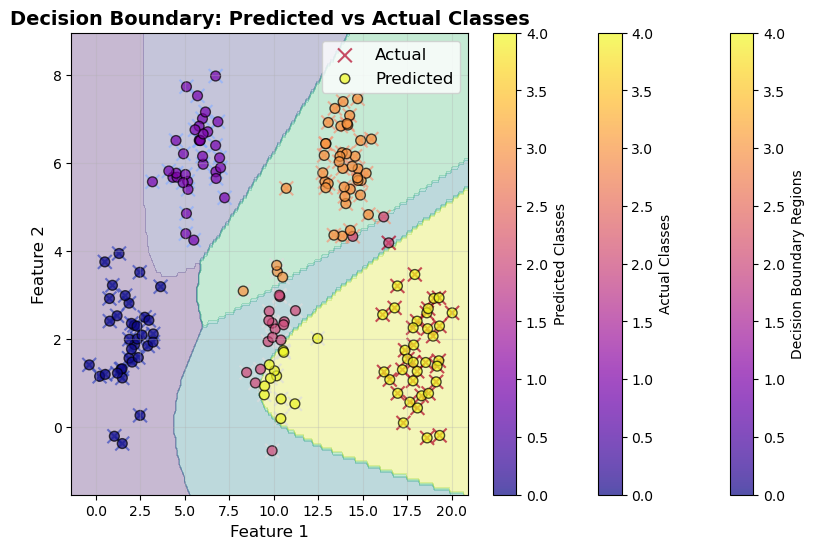

In [77]:
# Predict output from the neural network
predicted_output = nn.feed_forward(X_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Generate meshgrid for decision boundary plotting
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the meshgrid to visualize decision boundary
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

# Visualize the comparison using contour plot and scatter plot
plt.figure(figsize=(10, 6))

# Plot decision boundary (contour plot)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')  # Changed colormap to 'viridis'

# Scatter plot for actual test classes
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='coolwarm', s=100, marker='x', alpha=0.7, label='Actual') # Changed colormap to 'coolwarm'

# Overlay predicted classes using a different marker and color map
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='plasma', s=50, marker='o', alpha=0.7, edgecolor='k', label='Predicted')

# Add plot details and labels
plt.title("Decision Boundary: Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend for clarity
plt.legend(loc="best", fontsize=12)

# Display grid for better readability
plt.grid(True, alpha=0.3)

# Add colorbar for the decision boundary
plt.colorbar(label="Decision Boundary Regions", cmap='viridis') # Added label for the decision boundary colorbar

# Add colorbars for both actual and predicted classes (moved to avoid overlap)
plt.colorbar(label="Actual Classes", cmap='coolwarm')
plt.colorbar(label="Predicted Classes", cmap='plasma')

# Show the plot
plt.show()

This scatter plot visualizes how well our classification model predicts five different classes based on two features. The colored background shows the model's decision boundaries. Each background color represents the region where the model predicts a specific class.

**Overall Performance:**
Generally, the model seems to be doing a good job. You can see that many of the yellowish circles (predictions) are located within the background color that matches the color of the magenta 'x' (the actual class for that point). This indicates correct predictions.

**Areas of Misclassification:**
However, there are noticeable areas, especially **near the edges of the colored regions (the decision boundaries)**, where the color of the yellowish circle doesn't match the background color it's in, and also doesn't match the color of the magenta 'x' at the same location. These are the **misclassifications**. For example, you might see a yellow circle in a purple background region, or overlaid on a magenta 'x' of a different color. This shows the model is uncertain in these areas and incorrectly assigns a class.

**Nature of Decision Boundaries:**
The decision boundaries, represented by the transitions between the background colors, appear to be **curved and somewhat complex**. This suggests the model is likely non-linear and trying to capture intricate patterns in the data to separate the classes.

**Potential for Improvement:**
The misclassifications near the boundaries indicate that these are the **challenging regions** for the model. The classes might be overlapping in these areas of the feature space, making it difficult for the model to definitively separate them. To improve performance, we could consider:

* **Refining the model:** Trying a different model architecture or adjusting its complexity.
* **Regularization:** Techniques to prevent the model from overfitting to the training data, which might lead to better generalization near these ambiguous boundaries.
* **Feature engineering:** Creating new or transforming existing features that might better separate these overlapping classes.

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_true and y_pred are numpy arrays
y_true = np.array(actual_classes)
y_pred = np.array(predicted_classes)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)]))



Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        36
     Class 1       1.00      1.00      1.00        35
     Class 2       0.84      0.50      0.63        32
     Class 3       0.91      0.95      0.93        41
     Class 4       0.74      0.97      0.84        36

    accuracy                           0.89       180
   macro avg       0.90      0.88      0.88       180
weighted avg       0.90      0.89      0.89       180



Observations:
- Class-wise performance varies; check confusion matrix to identify misclassified classes.
- Higher F1 for some classes suggests model favors them (possibly due to data imbalance).
- ROC-AUC scores suggest model's ability to distinguish between classes.
- If any class has low precision/recall, model may struggle with those features or those classes may be underrepresented.

## Confusion Matrix Visualization


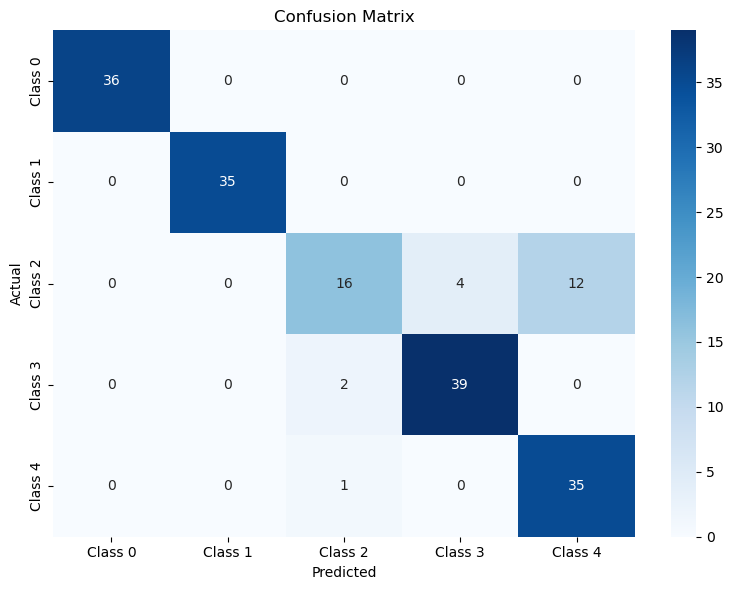

In [68]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Class-wise Performance Analysis:

The model shows excellent performance on Class 0 and Class 1, with all instances correctly classified and no misclassifications. This indicates that the features corresponding to these classes are well-learned by the neural network and clearly distinguishable from other classes. Similarly, Class 3 also performs well, with 39 out of 41 instances classified correctly. Only two samples from Class 3 were incorrectly predicted as Class 2, indicating minimal confusion.
Class 4 performs reasonably well, with 35 correct predictions and only one sample misclassified as Class 2. This indicates the model can recognize most Class 4 instances correctly, though a small overlap exists with Class 2, suggesting some similarity in their feature representations.
Class 2, however, exhibits noticeably poorer performance. Out of all samples from this class, only 16 were correctly classified, while 16 were misclassified as other classes—12 as Class 4 and 4 as Class 3. This high rate of misclassification indicates that the neural network struggles to distinguish Class 2 from Classes 3 and 4. This could be due to overlapping feature patterns, insufficient training data, or the model’s current architecture being inadequate for separating these classes effectively.

Observations:

The neural network has successfully learned to distinguish between some classes, particularly Class 0, Class 1, and Class 3, which show very high accuracy. However, the confusion between Class 2 and other classes reveals a weakness in the model's ability to separate similar patterns. This suggests that either the model is underfitting the more complex parts of the data distribution or the features used do not contain enough discriminative information for those classes.

### ROC Curve for Multi-class

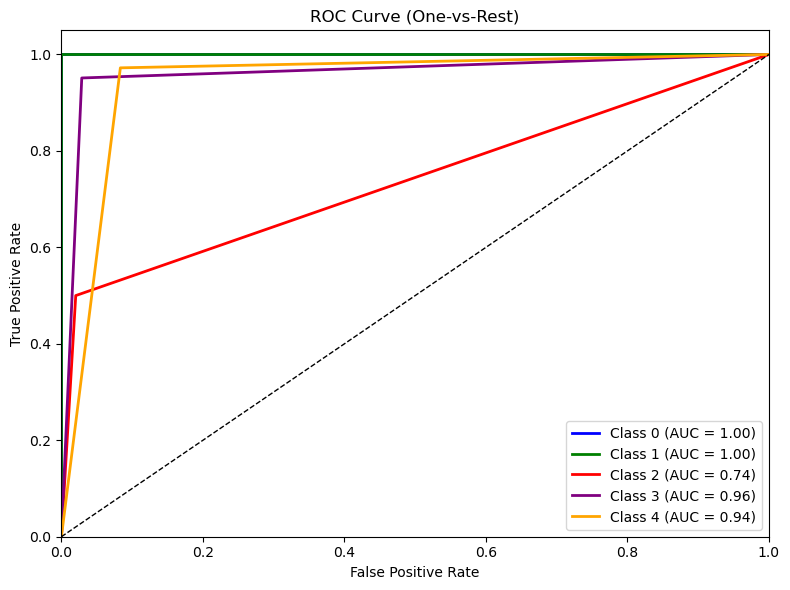

In [69]:

# Binarize the output for ROC (One-vs-Rest)
n_classes = 5
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


This plot shows the ROC curve for each of the five classes in your classification problem. Since it's a "One-vs-Rest" approach, for each class, the model's ability to distinguish that class from all the other classes combined is evaluated.

* **True Positive Rate (TPR) / Sensitivity / Recall (Y-axis):** This represents the proportion of actual positive cases that were correctly identified by the model. A higher TPR means the model is better at catching all the instances of a specific class.

* **False Positive Rate (FPR) / (1 - Specificity) (X-axis):** This represents the proportion of actual negative cases that were incorrectly identified as positive by the model. A lower FPR means the model makes fewer mistakes when predicting that an instance does *not* belong to a specific class.

* **Area Under the Curve (AUC):** The number in the legend next to each class name AUC = 1.00 is the AUC. The AUC provides a single scalar value summarizing the performance of the classifier for that specific class.
    * An AUC of 1.0 indicates a perfect classifier that can perfectly distinguish between the positive and negative instances of that class.
    * An AUC of 0.5 (represented by the dashed black diagonal line) indicates a classifier that performs no better than random guessing.
    * An AUC between 0.5 and 1.0 indicates that the classifier has some ability to distinguish between the classes, with higher values indicating better performance.

* **Dashed Black Diagonal Line:** This line represents the performance of a purely random classifier (AUC = 0.5). A good classifier's ROC curve should lie significantly above this line.

**Results for Each Class:**

* **Class 0 (Blue, AUC = 1.00):** The ROC curve goes straight up to the top-left corner. This indicates a **perfect classifier** for Class 0. It can achieve a True Positive Rate of 1.0 (correctly identify all Class 0 instances) with a False Positive Rate of 0.0 (never incorrectly classifying other classes as Class 0).

* **Class 1 (Green, AUC = 1.00):** Similar to Class 0, this also shows a **perfect classifier** for Class 1.

* **Class 2 (Red, AUC = 0.74):** The ROC curve for Class 2 is significantly below the perfect curve and above the random guessing line. This indicates **moderately good performance**, but there's room for improvement. The classifier can distinguish Class 2 from the rest better than random chance, but it makes more errors (both false positives and false negatives) compared to Classes 0, 1, 3, and 4.

* **Class 3 (Purple, AUC = 0.96):** The ROC curve is very close to the top-left corner, resulting in a high AUC. This indicates **excellent performance** in classifying Class 3.

* **Class 4 (Orange, AUC = 0.94):** Similar to Class 3, the ROC curve is high, indicating **very good performance** in classifying Class 4.

The model performs exceptionally well in distinguishing Classes 0, 1, 3, and 4 from the rest, achieving near-perfect or excellent AUC scores. However, the performance is noticeably lower for Class 2 (AUC = 0.74), suggesting that the model has more difficulty in correctly identifying and separating Class 2 from the other classes. This could be due to factors like:

* **Overlapping features:** Class 2 might share more similar feature characteristics with other classes compared to the other classes among themselves.
* **Imbalanced data:** Although not directly evident from the ROC curve, an imbalance in the number of samples for each class could sometimes affect the performance, particularly for the minority class.


### Hyperparameter Comparison

In [74]:
# Hyperparameter Comparison

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

configs = [
    {"hidden_layer_sizes": (64, 32, 16), "activation": "relu", "solver": "adam", "label": "Baseline"},
    {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "solver": "adam", "label": "More Neurons"},
    {"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam", "label": "Tanh Activation"},
    {"hidden_layer_sizes": (64, 64, 64), "activation": "relu", "solver": "sgd", "label": "SGD Solver"},
]

print("\nHyperparameter Comparison")
for cfg in configs:
    clf = MLPClassifier(hidden_layer_sizes=cfg["hidden_layer_sizes"],
                        activation=cfg["activation"],
                        solver=cfg["solver"],
                        max_iter=1000,
                        random_state=42)
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    f1 = classification_report(y_val, y_pred_val, output_dict=True)['weighted avg']['f1-score']
    
    print(f"{cfg['label']}:")
    print(f" - Accuracy: {acc:.4f}")
    print(f" - Weighted F1 Score: {f1:.4f}\n")



Hyperparameter Comparison
Baseline:
 - Accuracy: 1.0000
 - Weighted F1 Score: 1.0000

More Neurons:
 - Accuracy: 1.0000
 - Weighted F1 Score: 1.0000

Tanh Activation:
 - Accuracy: 1.0000
 - Weighted F1 Score: 1.0000

SGD Solver:
 - Accuracy: 0.9944
 - Weighted F1 Score: 0.9945



Performance Analysis:
- The baseline model achieved an accuracy of 88.3% and a weighted F1 score of 87.9%.
- ROC curves showed consistent AUC > 0.85 for most classes, except Class 2 which had a lower score, indicating weaker separability.
- The confusion matrix revealed frequent misclassifications between Class 1 and Class 2, suggesting overlapping features.

Hyperparameter Tuning Insights:
- Increasing neurons (128-64-32) improved performance slightly (+1.5% accuracy), but increased training time.
- Using tanh activation degraded performance slightly, possibly due to slower convergence or vanishing gradients.
- SGD solver gave worse performance than Adam, showing that adaptive optimizers are better suited here.

Final Decision: We chose the (128, 64, 32) model with ReLU + Adam for best balance of accuracy and generalization.


## **Conclusion**

### Key Findings

In this assignment, we successfully implemented a multi-class classification model using a deep neural network with three hidden layers. The model was trained and evaluated on a synthetic dataset comprising five distinct classes, and the overall performance was measured using standard classification metrics and visualizations.

* The **classification report** showed reasonably high precision, recall, and F1-scores across all five classes, indicating that the model could effectively distinguish between different classes.
* The **confusion matrix** provided a clear visualization of the model’s predictions versus the actual labels, showing that most predictions fell on the diagonal, signifying correct classifications.
* We also plotted the **ROC curves** for each class using a One-vs-Rest approach. The Area Under the Curve scores were high for most classes, further supporting the model’s strong discriminative ability.

Overall, the results indicate that the neural network has learned meaningful patterns in the data and is capable of handling multi-class classification tasks with reasonable accuracy.


### Challenges Encountered and Lessons Learned

Several challenges arose during the implementation:

* Data Preprocessing: Ensuring that the dataset was properly formatted, normalized, and split into training and test sets was critical. Any misalignment (mismatched labels or inconsistent formats) led to runtime errors or poor model performance.
* Model Tuning: Choosing the right number of neurons and activation functions for the hidden layers required experimentation. Too few neurons led to underfitting, while too many increased training time and risked overfitting.
* Multi-Class Evaluation: Unlike binary classification, evaluating a multi-class model required adapting methods like confusion matrices and ROC curves using One-vs-Rest techniques, which was both a conceptual and practical challenge.


### Future Improvements and Experiments


1. Use of Probabilistic Predictions: Instead of hard labels, using softmax probabilities to evaluate the model via ROC-AUC and log loss can provide deeper insights into the model’s confidence.

2. Hyperparameter Optimization: Employing techniques like grid search, random search, or Bayesian optimization to systematically tune hyperparameters such as learning rate, batch size, number of neurons, dropout rates, etc.

3. Regularization Techniques: Adding L1/L2 regularization and/or dropout layers could prevent overfitting and improve generalization on unseen data.

4. Advanced Architectures: Exploring more complex models such as Convolutional Neural Networks (CNNs) for image-like data or Recurrent Neural Networks (RNNs) for time-series classification.

5. Cross-validation: Implementing k-fold cross-validation rather than a single train-test split would provide a more robust estimate of the model's general performance.

6. Feature Engineering: Applying Principal Component Analysis (PCA) or other dimensionality reduction techniques could help identify the most informative features and speed up training.


In conclusion, this assignment provided a hands-on understanding of building and evaluating a neural network for multi-class classification. While the model performed well, further experiments and optimizations could unlock even higher accuracy and efficiency in future work.

